<a href="https://colab.research.google.com/github/rubyvanrooyen/observation_planning/blob/main/comet67P/67P_occulation_pointing_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeerKAT pointing calculations for comet 67P/Churyumov-Gerasimenko

## Library Installation

Use `skyfield` python package and published data files downloaded from the Minor Planet Center.    
https://rhodesmill.org/skyfield/kepler-orbits.html

In [ ]:
!pip install skyfield

     |████████████████████████████████| 378kB 5.8MB/s 
     |████████████████████████████████| 40kB 5.2MB/s 
     |████████████████████████████████| 266kB 41.6MB/s 
  Created wheel for skyfield: filename=skyfield-1.39-cp37-none-any.whl size=417583 sha256=f1fc06f921c78103f1fb35756a689e60197a7aab199f999fd2bf1e3e00f0e7e2
  Stored in directory: /root/.cache/pip/wheels/bb/a4/a6/2f7e3bc8ec08ffc7485c92d18dd726e0dbafc0f7a8b1519518
  Created wheel for jplephem: filename=jplephem-2.16-cp37-none-any.whl size=46796 sha256=b786ec6151db1199c6f49923b373f68facc2f0e7f7e75e4eff52c4fa8a7d8d2f
  Stored in directory: /root/.cache/pip/wheels/6c/fe/9f/25afac10d5ef069cde1a252301efdf05401cb9a4ce42356788
Successfully built skyfield jplephem


Skyfield loads orbital elements from text files using the Pandas library.

In [ ]:
!pip install pandas

Library functions used in calculations

In [ ]:
!pip install git+https://github.com/ska-sa/astrokat.git

In [ ]:
!git clone https://github.com/ska-sa/astrokat.git

Cloning into 'astrokat'...
remote: Enumerating objects: 3349, done.
remote: Counting objects: 100% (811/811), done.
remote: Compressing objects: 100% (407/407), done.
remote: Total 3349 (delta 528), reused 650 (delta 402), pack-reused 2538
Receiving objects: 100% (3349/3349), 6.15 MiB | 27.39 MiB/s, done.
Resolving deltas: 100% (2304/2304), done.


In [ ]:
!ln -s /content/astrokat/scripts/astrokat-targets.py mkatcals.py

In [ ]:
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.api import load, Topos
from skyfield.api import S, E, wgs84
from skyfield.data import mpc

from datetime import timedelta, datetime, timezone

from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, AltAz
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.time import Time

import numpy as np

import astrokat
import mkatcals

## Occulation source

```
Date, UT, source miss distance (arcmin), flux(Jy), RA, DEC (degrees)
July 25   6.1  0.6 1091.2  20.254303   3.737438 
	The comet is to pass 0.6’ from the source ca 2 hours after the highest elevation
```

20.2502 3.739088888888889

Observation Table for 2021/7/25 00:00:00 (UTC)
Times listed in LST for target rise and set times
Target visible when above 14.999999999999998 degrees
Sources         Class                           RA              Decl            Rise Time       Set Time        Separation      Notes           
3c39            radec target                    1:21:00.05      3:44:20.7       20:42:01.84     6:02:10.96      101.84          Separation from Sun
J0059+0006      radec bpcal                     0:59:05.51      0:06:51.6       20:10:50.63     5:49:32.10      6.56            Separation from 3c39
J0108+0134      radec gaincal                   1:08:38.77      1:35:00.3       20:24:06.16     5:55:23.41      3.76                            
J0408-6545      radec bpcal fluxcal             4:08:20.38      -65:45:09.1     19:45:36.61     12:31:20.77     75.76 ***                       



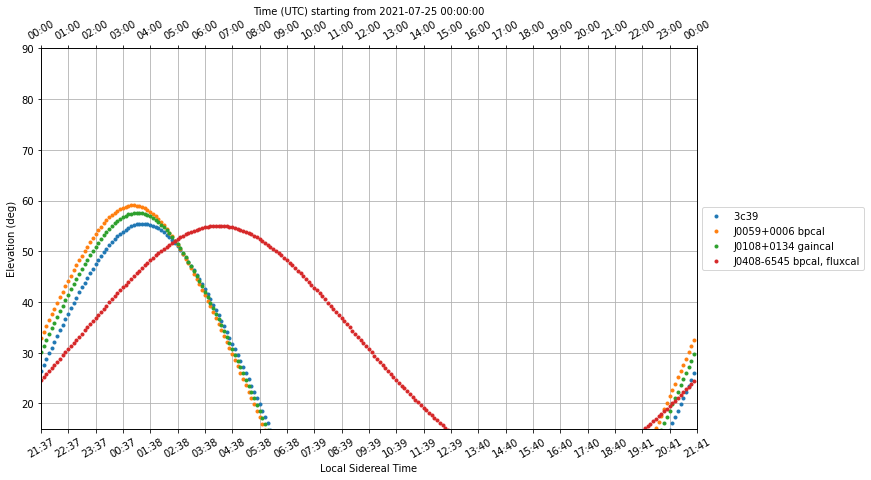

In [ ]:
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

_3c39_ = SkyCoord('01h21m01.243s', '+03d44m14.39s', frame='icrs')
_3c39_ = SkyCoord('01h21m00.048s', '+03d44m20.72s', frame='icrs')
print(_3c39_.ra.degree, _3c39_.dec.degree)

target = ['3c39', '01:21:00.048', '03:44:20.72']
cal_tags = ['gain', 'flux', 'bp']

mkatcals.main(creation_time = '2021-07-25 00:00',
              horizon=15,
              target=target,
              cal_tags=cal_tags,
              mkat_catalogues='/content/astrokat/catalogues',
              lst=True)

## Comet target definition
Use Skyfield to map comet ephemeris to sky coordinates given date of interest

In [ ]:
comet_name = '67P/Churyumov-Gerasimenko'

Build a dataframe of comets

In [ ]:
with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)
# Keep only the most recent orbit for each comet,
# and index by designation for fast lookup.
comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

print(len(comets), 'comets loaded')
print(mpc.COMET_URL)

[#################################] 100% CometEls.txt


898 comets loaded
https://www.minorplanetcenter.net/iau/MPCORB/CometEls.txt


Read ephemeris of selected comet.    
Cometary orbits are measured centered on the Sun.

You will therefore need to add the barycenter->Sun vector to the Sun->comet vector to produce a position that you can pass to the `observe()` method, which always measures positions from the Solar System barycenter.

In [ ]:
ts = load.timescale()
eph = load('de421.bsp')
sun, earth = eph['sun'], eph['earth']

ephem = comets.loc[comet_name]
print(ephem)
comet = sun + mpc.comet_orbit(ephem, ts, GM_SUN)
print(comet)

[#################################] 100% de421.bsp


designation                            67P/Churyumov-Gerasimenko
perihelion_year                                             2021
perihelion_month                                              11
perihelion_day                                            2.0541
perihelion_distance_au                                   1.21064
eccentricity                                            0.649797
argument_of_perihelion_degrees                            22.126
longitude_of_ascending_node_degrees                      36.3341
inclination_degrees                                       3.8713
magnitude_g                                                   11
magnitude_k                                                    4
reference                                          MPEC 2021-N06
Name: 67P/Churyumov-Gerasimenko, dtype: object
Sum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
 _KeplerOrbit 10 SUN -> str


## Pointing calculations

In [ ]:
year = 2021
month = 7
day = 25

Topocentric coordinates specific to MeerKAT telescope's location on the Earth’s surface

In [ ]:
# Apparent topocentric position
meerkat = earth + Topos('30.7130 S', '21.4430 E')
# meerkat = earth + wgs84.latlon(30.7130 * S, 21.4430 * E)

location = EarthLocation.from_geodetic(Longitude('21:26:38.0',
                                                 u.degree,
                                                 wrap_angle=180. * u.degree,
                                                 copy=False),
                                       Latitude('-30:42:39.8',
                                                u.degree,
                                                copy=False),
                                       height=u.Quantity(1086.6,
                                                         u.m,
                                                         copy=False))

In [ ]:
UTC = timezone(timedelta(hours=0))
t = ts.utc(year, month, day)
obs_date = datetime(year, month, day, 0, 0, 0, tzinfo=UTC)

# nr seconds in day sampled at some decimation interval
decimate = 30  # sec
time_samples = range(0, 24*3600, decimate)  # sec

Relating the coordinates to ephem definition and katpoint:

* The position of a body is stored as the **Astrometric geocentric position**.
The epoch defaults to `J2000` and hence no precession gets applied.
These values are available as `a_ra` and `a_dec`.

* To calculate where the object will "appear" for an observer at the center of the Earth, apply corrections for light-travel time (for solar system objects), gravitational deflection of light, nutation and aberration to the astrometric position.
This position refers to the orientation of the Earth’s axes at the given date and time and hence are referred to as "epoch-of-date" coordinates;
this will not be same as star atlas position. This position is stored as **Apparent geocentric position** and are available as `g_ra` and `g_dec`.

* 
If an `Observer` (`Location`) is specified, parallax corrections are applied to `g_ra` and` g_dec`, to get the apparent position of the body as seen by the Observer on the surface of the Earth.
This position is called the **Apparent topocentric position** and are stored as `ra` and `dec`.
At the `Observer`‘s date and time, the `alt` and `az` properties defining the object's position in the sky is calculated.

$r = D \tan(\rho)$, with $\rho = 49''$ major axis sizes

In [ ]:
# comet celestial coordinates using skyfield
a_RA = []
a_Decl = []
RA_deg = []
RA = []
Decl = []
Distances = []
Alt = []
Az = []
Datetimes = []
for time_cnt in time_samples:
    t = ts.from_datetime(obs_date + timedelta(seconds=time_cnt))
    Datetimes.append(t.utc_datetime())

    astrometric = meerkat.at(t).observe(comet)
    a_ra, a_dec, dist = astrometric.radec()
    a_RA.append(a_ra.hours)
    a_Decl.append(a_dec.degrees)
    Distances.append(dist.au)

    apprent = astrometric.apparent()
    ra, dec, _ = apprent.radec()
    RA.append(ra.hours)
    RA_deg.append(ra._degrees)
    Decl.append(dec.degrees)
    alt, az, _ = apprent.altaz()
    Alt.append(alt.degrees)
    Az.append(az.degrees)

#return Datetimes, a_RA, a_Decl, RA, Decl, Distances, Alt, Az


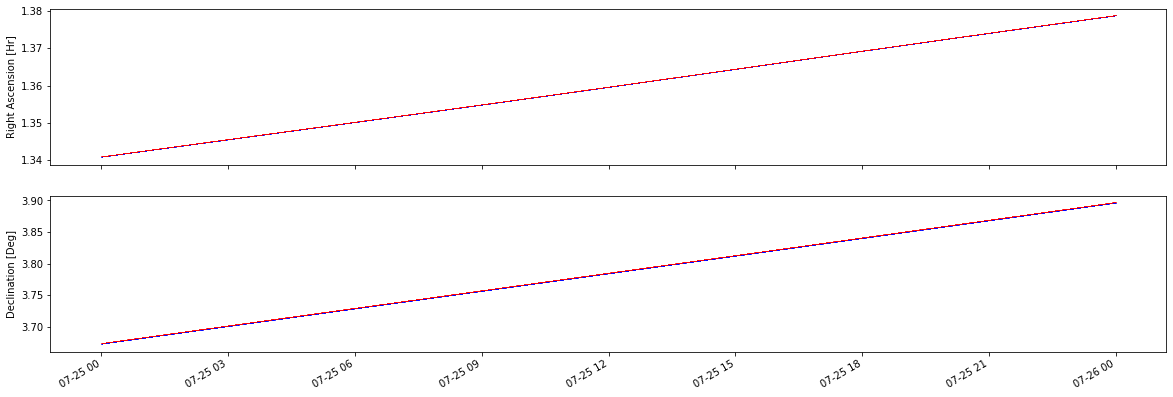

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
dates = matplotlib.dates.date2num(Datetimes)

plt.figure
fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(20, 7),  # W x H
                        facecolor='white')
axs[0].plot_date(dates, a_RA, 'b,', alpha=0.7)
axs[0].plot_date(dates, RA, 'r,', alpha=0.7)
axs[0].set_ylabel('Right Ascension [Hr]')
axs[1].plot_date(dates, a_Decl, 'b,', alpha=0.7)
axs[1].plot_date(dates, Decl, 'r,', alpha=0.7)
axs[1].set_ylabel('Declination [Deg]')

# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.show()

## Separation angle

In [ ]:
separation = []
cnt = 0
for (ra_hr, dec_deg, dist_au) in zip(RA, Decl, Distances):
    _67P_ = SkyCoord(ra_hr*u.hour, dec_deg*u.degree, frame='icrs')
    separation.append(_3c39_.separation(_67P_).degree)
    # print(f"On {Datetimes[cnt]} comet @ coords {_67P_.to_string('hmsdms')} separation angle {_3c39_.separation(_67P_).degree} [deg]")
    cnt+=1

In [ ]:
obs_start_dt = Datetimes[start_date_idx].strftime(format="%Y-%m-%d %H:%M")
obs_end_t = Datetimes[end_date_idx].strftime(format="%H:%M")
title = f'Occultation observation over {obs_start_dt} to {obs_end_t} UTC'
print(title)

Occulation observation over 2021-07-25 04:08 to 08:08 UTC


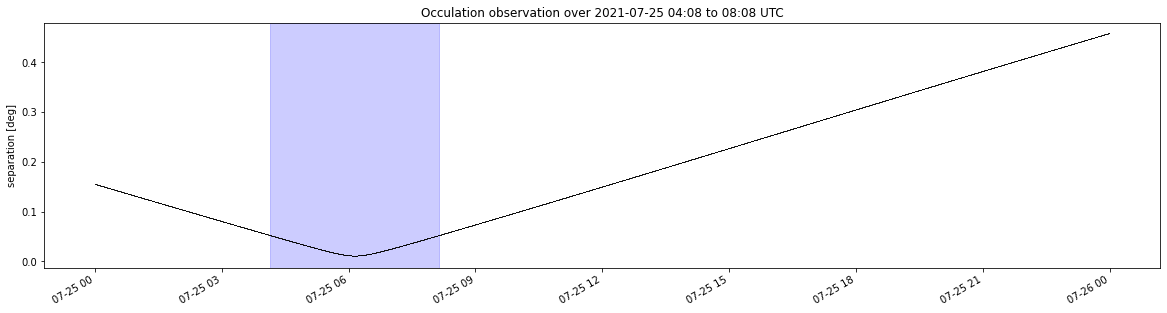

In [ ]:
min_sep_idx = np.argmin(separation)
start_date_idx = min_sep_idx-5*48
end_date_idx = min_sep_idx+5*48

plt.figure
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(20, 5),  # W x H
                       facecolor='white')
ax.plot_date(dates, separation, 'k,', alpha=0.7)
ax.axvspan(dates[start_date_idx], dates[end_date_idx], alpha=0.2, color='blue')
ax.set_title(title)
ax.set_ylabel('separation [deg]')
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.savefig('Occulation67P.png')
plt.show()

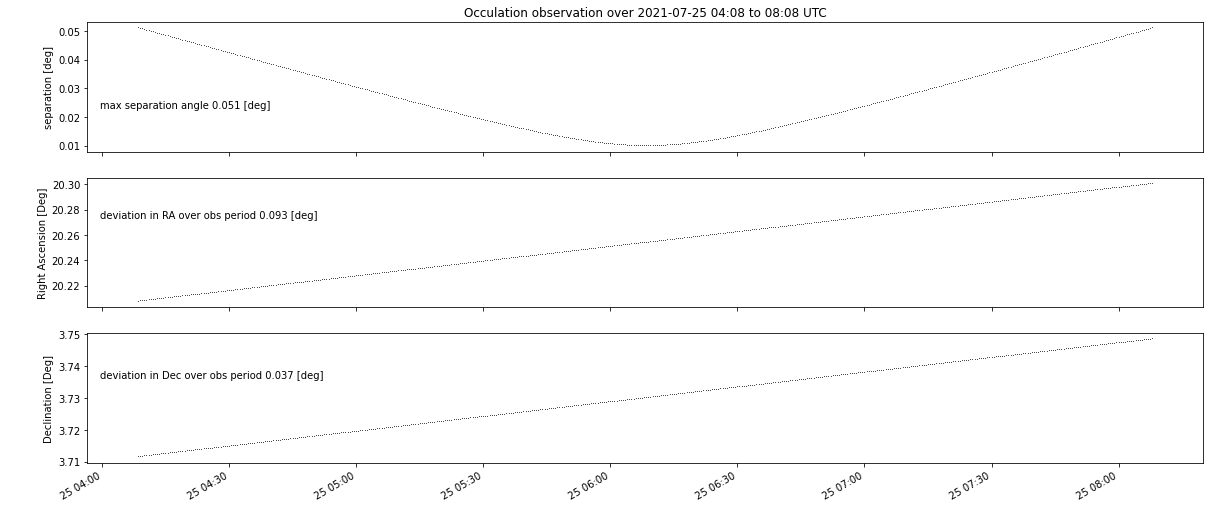

In [ ]:
min_sep_idx = np.argmin(separation)
start_date_idx = min_sep_idx-5*48
end_date_idx = min_sep_idx+5*48

plt.figure
fig, axs = plt.subplots(nrows=3, ncols=1,
                        figsize=(20, 9),  # W x H
                        facecolor='white')
axs[0].plot_date(dates[start_date_idx:end_date_idx],
                 separation[start_date_idx:end_date_idx], 'k,', alpha=0.7)
axs[0].set_title(title)
axs[0].set_ylabel('separation [deg]')
axs[0].annotate(f'max separation angle {np.max(separation[start_date_idx:end_date_idx]):.3f} [deg]',
            xy=(100, 400), xycoords='figure points')

axs[1].plot_date(dates[start_date_idx:end_date_idx],
                 RA_deg[start_date_idx:end_date_idx], 'k,', alpha=0.7)
axs[1].set_ylabel('Right Ascension [Deg]')
anno = f'deviation in RA over obs period {np.max(RA_deg[start_date_idx:end_date_idx])-np.min(RA_deg[start_date_idx:end_date_idx]):.3f} [deg]'
axs[1].annotate(anno, xy=(100, 290), xycoords='figure points')

axs[2].plot_date(dates[start_date_idx:end_date_idx],
                 Decl[start_date_idx:end_date_idx], 'k,', alpha=0.7)
axs[2].set_ylabel('Declination [Deg]')
anno = f'deviation in Dec over obs period {np.max(Decl[start_date_idx:end_date_idx])-np.min(Decl[start_date_idx:end_date_idx]):.3f} [deg]'
axs[2].annotate(anno, xy=(100, 130), xycoords='figure points')

# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.savefig('Occulation67P.png')
plt.show()

In [ ]:
def create_target(name, skycoord):
    ra_hms = skycoord.ra.hms
    ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
    dec_dms = skycoord.dec.dms
    dec_str = f'{int(dec_dms[0])}:{int(dec_dms[1])}:{dec_dms[2]:.3f}'

    tgt_str = f'{name}, radec target, {ra_str}, {dec_str}'
    return tgt_str
    
# 30 second samples over 15 minutes
# 15 minutes sampled every 30 seconds (twice per minute)
step = 15*2
time_range = time_samples[start_date_idx:end_date_idx]
sky_coords = []
sky_dates = []
for dt in time_range[::step]:
    t = ts.from_datetime(obs_date + timedelta(seconds=dt))
    sky_dates.append(t.utc_datetime())
    a_ra, a_dec, dist = meerkat.at(t).observe(comet).radec()
    sky_coords.append(SkyCoord(a_ra.hours*u.hour, a_dec.degrees*u.degree, frame='icrs'))

comet_deviation = []
comet_pointings = []
for cnt, dt in enumerate(sky_dates):
    if cnt > len(sky_dates)-2: break
    c0 = sky_coords[cnt]
    c1 = sky_coords[cnt+1]
    separation = c0.separation(c1)
    comet_deviation.append(separation.arcsecond)
    print(f'On {dt} comet will have moved {separation.arcsecond:.3f} [arcsec] from previous pointing')
    line = create_target('67P', c0)
    print(line)
    comet_pointings.append(line)
    
obsfile = 'comet67P_pointings.csv'
with open(obsfile, 'w') as fout:
    for line in comet_pointings:
        fout.write(line+"\n")

On 2021-07-25 04:08:30+00:00 comet will have moved 22.441 [arcsec] from previous pointing
67P, radec target, 1:20:49.514, 3:42:37.977
On 2021-07-25 04:23:30+00:00 comet will have moved 22.446 [arcsec] from previous pointing
67P, radec target, 1:20:50.906, 3:42:46.325
On 2021-07-25 04:38:30+00:00 comet will have moved 22.453 [arcsec] from previous pointing
67P, radec target, 1:20:52.298, 3:42:54.672
On 2021-07-25 04:53:30+00:00 comet will have moved 22.462 [arcsec] from previous pointing
67P, radec target, 1:20:53.690, 3:43:3.017
On 2021-07-25 05:08:30+00:00 comet will have moved 22.472 [arcsec] from previous pointing
67P, radec target, 1:20:55.084, 3:43:11.362
On 2021-07-25 05:23:30+00:00 comet will have moved 22.484 [arcsec] from previous pointing
67P, radec target, 1:20:56.478, 3:43:19.705
On 2021-07-25 05:38:30+00:00 comet will have moved 22.498 [arcsec] from previous pointing
67P, radec target, 1:20:57.872, 3:43:28.046
On 2021-07-25 05:53:30+00:00 comet will have moved 22.512 [arcs

In [ ]:
obsfile = 'comet67P_pointings.csv'
with open(obsfile, 'w') as fout:
    line = create_target('67P_occult_start', _67P_start)
    fout.write(line+"\n")
    line = create_target('67P_occult', _67P_occult)
    fout.write(line+"\n")
    line = create_target('67P_occult_end', _67P_end)
    fout.write(line+"\n")
    line = create_target('3C 39', _3c39_)
    fout.write(line+"\n")

occult_dt = Datetimes[0].strftime(format="%Y-%m-%d %H:%M")
cal_tags = ['gain', 'flux', 'bp']
mkatcals.main(creation_time=occult_dt,
              horizon=15,
              infile=obsfile,
              al_tags=cal_tags,
              mkat_catalogues='/content/astrokat/catalogues',
              lst=True)

Occulation observation over 2021-07-25 04:08 to 08:08 UTC

Calibrators from 3C39 background source
```
Sources         Class                           RA              Decl
J0108+0134      radec gaincal                   1:08:38.77      1:35:00.3
J0408-6545      radec bpcal fluxcal             4:08:20.38      -65:45:09.1
```

In [ ]:
c0 = sky_coords[0]
c1 = sky_coords[-1]
separation = c0.separation(c1)
print(f'Comet will have move {separation.degree:.1f} [deg] ({separation.arcmin:.3f} [arcmin] ) over observation period')

Comet will have move 0.1 [deg] (5.631 [arcmin] ) over observation period


## Observational coordinates

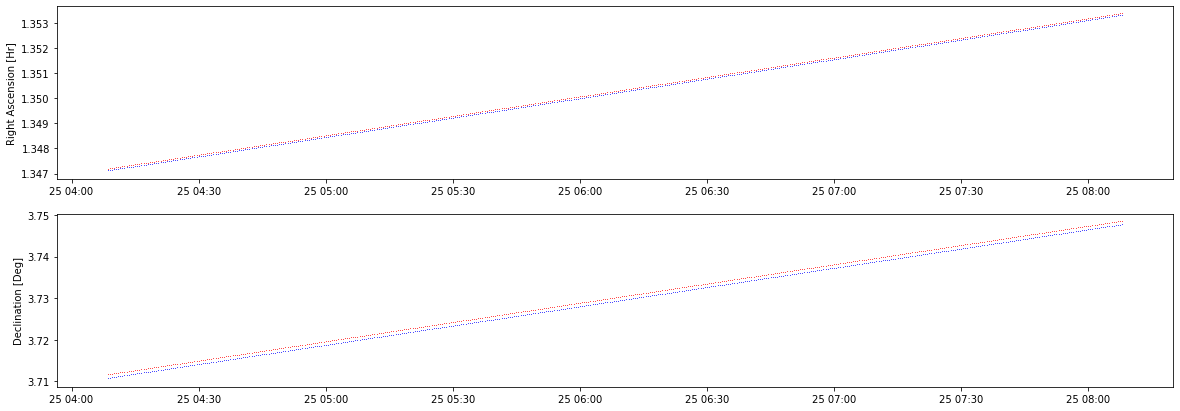

In [ ]:
# plot (ra, dec) over the selected occulation time range
plt.figure
fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(20, 7),  # W x H
                        facecolor='white')
axs[0].plot_date(dates[start_date_idx:end_date_idx],
                 a_RA[start_date_idx:end_date_idx], 'b,', alpha=0.7)
axs[0].plot_date(dates[start_date_idx:end_date_idx],
                 RA[start_date_idx:end_date_idx], 'r,', alpha=0.7)
axs[0].set_ylabel('Right Ascension [Hr]')
axs[1].plot_date(dates[start_date_idx:end_date_idx],
                 a_Decl[start_date_idx:end_date_idx], 'b,', alpha=0.7)
axs[1].plot_date(dates[start_date_idx:end_date_idx],
                 Decl[start_date_idx:end_date_idx], 'r,', alpha=0.7)
axs[1].set_ylabel('Declination [Deg]')
plt.show()

In [ ]:
# start coord
ra = RA[start_date_idx]
dec = Decl[start_date_idx]
_67P_start = SkyCoord(ra=ra*u.hour, dec=dec*u.deg, frame='icrs')
obs_time = Time(Datetimes[start_date_idx])
observer = AltAz(location=location, obstime=obs_time)
altaz = _67P_start.transform_to(observer)
print(altaz.alt.deg, altaz.az.deg)
print(Alt[start_date_idx], Az[start_date_idx])


# occulation coord
ra = RA[min_sep_idx]
dec = Decl[min_sep_idx]
_67P_occult = SkyCoord(ra=ra*u.hour, dec=dec*u.deg, frame='icrs')
obs_time = Time(Datetimes[min_sep_idx])
observer = AltAz(location=location, obstime=obs_time)
altaz = _67P_occult.transform_to(observer)
print(altaz.alt.deg, altaz.az.deg)
print(Alt[min_sep_idx], Az[min_sep_idx])

# end coord
ra = RA[end_date_idx]
dec = Decl[end_date_idx]
_67P_end = SkyCoord(ra=ra*u.hour, dec=dec*u.deg, frame='icrs')
obs_time = Time(Datetimes[end_date_idx])
observer = AltAz(location=location, obstime=obs_time)
altaz = _67P_end.transform_to(observer)
print(altaz.alt.deg, altaz.az.deg)
print(Alt[end_date_idx], Az[end_date_idx])

54.965089335898156 349.2204106637907
54.963961710059046 349.2205377995343
41.13919077564547 308.491301653481
41.1384802117721 308.49186971976314
18.126237673646557 286.07261647071067
18.12605539872059 286.0725584170187


## Elevation plots


Observation Table for 2021/7/25 00:00:00 (UTC)
Times listed in LST for target rise and set times
Target visible when above 14.999999999999998 degrees
Sources         Class                           RA              Decl            Rise Time       Set Time        Separation      Notes           
3C 39           radec target                    1:21:00.05      3:44:20.7       20:42:01.84     6:02:10.96      101.84          Separation from Sun
67P_occult      radec target                    1:21:00.91      3:43:47.8       20:42:01.26     6:02:13.26      101.84                          
67P_occult_end  radec target                    1:21:12.13      3:44:54.5       20:42:15.39     6:02:21.57      101.79                          
67P_occult_startradec target                    1:20:49.76      3:42:41.0       20:41:47.19     6:02:05.03      101.89                          
J0108+0134      radec gaincal                   1:08:38.77      1:35:00.3       20:24:06.16     5:55:23.41      3.71     

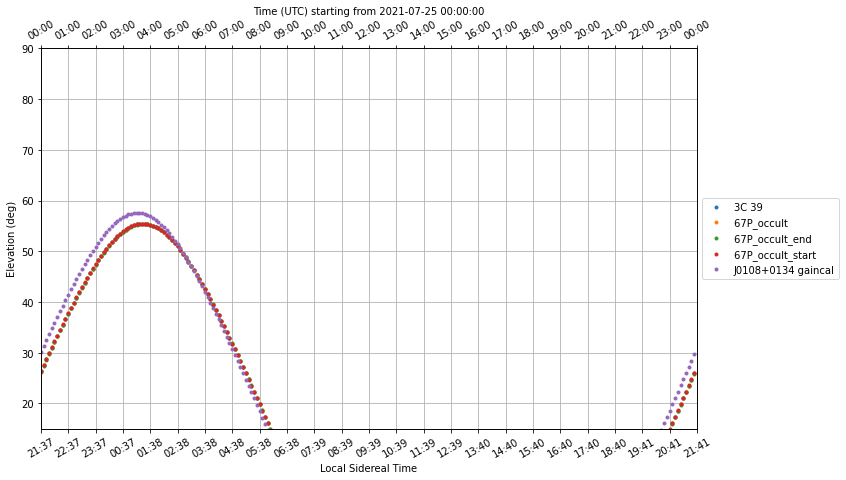

In [ ]:
def create_target(name, skycoord):
    ra_hms = skycoord.ra.hms
    ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
    dec_dms = skycoord.dec.dms
    dec_str = f'{int(dec_dms[0])}:{int(dec_dms[1])}:{dec_dms[2]:.3f}'

    tgt_str = f'{name}, radec target, {ra_str}, {dec_str}'
    return tgt_str

obsfile = 'comet67P_occultation.csv'
with open(obsfile, 'w') as fout:
    line = create_target('67P_occult_start', _67P_start)
    fout.write(line+"\n")
    line = create_target('67P_occult', _67P_occult)
    fout.write(line+"\n")
    line = create_target('67P_occult_end', _67P_end)
    fout.write(line+"\n")
    line = create_target('3C 39', _3c39_)
    fout.write(line+"\n")

occult_dt = Datetimes[0].strftime(format="%Y-%m-%d %H:%M")
cal_tags = ['gain', 'flux', 'bp']
mkatcals.main(creation_time=occult_dt,
              horizon=15,
              infile=obsfile,
              al_tags=cal_tags,
              mkat_catalogues='/content/astrokat/catalogues',
              lst=True)